# softmax回归的从零开始实现
:label:`sec_softmax_scratch`

(**就像我们从零开始实现线性回归一样，**)
我们认为softmax回归也是重要的基础，因此(**应该知道实现softmax回归的细节**)。
本节我们将使用刚刚在 :numref:`sec_fashion_mnist`中引入的Fashion-MNIST数据集，
并设置数据迭代器的批量大小为256。


In [1]:
import torch
from IPython import display
from myd2l import torch as d2l

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 初始化模型参数

和之前线性回归的例子一样，这里的每个样本都将用固定长度的向量表示。
原始数据集中的每个样本都是$28 \times 28$的图像。
本节[**将展平每个图像，把它们看作长度为784的向量。**]
在后面的章节中，我们将讨论能够利用图像空间结构的特征，
但现在我们暂时只把每个像素位置看作一个特征。

回想一下，在softmax回归中，我们的输出与类别一样多。
(**因为我们的数据集有10个类别，所以网络输出维度为10**)。
因此，权重将构成一个$784 \times 10$的矩阵，
偏置将构成一个$1 \times 10$的行向量。
与线性回归一样，我们将使用正态分布初始化我们的权重`W`，偏置初始化为0。


In [3]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

## 定义softmax操作

在实现softmax回归模型之前，我们简要回顾一下`sum`运算符如何沿着张量中的特定维度工作。
如 :numref:`subseq_lin-alg-reduction`和
 :numref:`subseq_lin-alg-non-reduction`所述，
 [**给定一个矩阵`X`，我们可以对所有元素求和**]（默认情况下）。
 也可以只求同一个轴上的元素，即同一列（轴0）或同一行（轴1）。
 如果`X`是一个形状为`(2, 3)`的张量，我们对列进行求和，
 则结果将是一个具有形状`(3,)`的向量。
 当调用`sum`运算符时，我们可以指定保持在原始张量的轴数，而不折叠求和的维度。
 这将产生一个具有形状`(1, 3)`的二维张量。


In [4]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

回想一下，[**实现softmax**]由三个步骤组成：

1. 对每个项求幂（使用`exp`）；
1. 对每一行求和（小批量中每个样本是一行），得到每个样本的规范化常数；
1. 将每一行除以其规范化常数，确保结果的和为1。

在查看代码之前，我们回顾一下这个表达式：

(**
$$
\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.
$$
**)

分母或规范化常数，有时也称为*配分函数*（其对数称为对数-配分函数）。
该名称来自[统计物理学](https://en.wikipedia.org/wiki/Partition_function_(statistical_mechanics))中一个模拟粒子群分布的方程。


In [5]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

正如上述代码，对于任何随机输入，[**我们将每个元素变成一个非负数。
此外，依据概率原理，每行总和为1**]。


In [6]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X) #将正负随机的正态分布进行softmax变成全为非负的概率

X,X_prob, X.sum(1, keepdim=True),X_prob.sum(1, keepdim=False),X_prob.sum(1, keepdim=False).shape,X_prob.sum(1, keepdim=True),X_prob.sum(1, keepdim=True).shape

(tensor([[-0.1275, -1.0789,  1.8878, -1.0318, -0.6176],
         [-1.2156, -1.0904, -0.1536,  0.4392,  0.6810]]),
 tensor([[0.1009, 0.0390, 0.7574, 0.0409, 0.0618],
         [0.0591, 0.0670, 0.1709, 0.3092, 0.3938]]),
 tensor([[-0.9680],
         [-1.3394]]),
 tensor([1.0000, 1.0000]),
 torch.Size([2]),
 tensor([[1.0000],
         [1.0000]]),
 torch.Size([2, 1]))

注意，虽然这在数学上看起来是正确的，但我们在代码实现中有点草率。
矩阵中的非常大或非常小的元素可能造成数值上溢或下溢，但我们没有采取措施来防止这点。

## 定义模型

定义softmax操作后，我们可以[**实现softmax回归模型**]。
下面的代码定义了输入如何通过网络映射到输出。
注意，将数据传递到模型之前，我们使用`reshape`函数将每张原始图像展平为向量。


In [7]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

## 定义损失函数

接下来，我们实现 :numref:`sec_softmax`中引入的交叉熵损失函数。
这可能是深度学习中最常见的损失函数，因为目前分类问题的数量远远超过回归问题的数量。

回顾一下，交叉熵采用真实标签的预测概率的负对数似然。
这里我们不使用Python的for循环迭代预测（这往往是低效的），
而是通过一个运算符选择所有元素。
下面，我们[**创建一个数据样本`y_hat`，其中包含2个样本在3个类别的预测概率，
以及它们对应的标签`y`。**]
有了`y`，我们知道在第一个样本中，第一类是正确的预测；
而在第二个样本中，第三类是正确的预测。
然后(**使用`y`作为`y_hat`中概率的索引**)，
我们选择第一个样本中第一个类的概率和第二个样本中第三个类的概率。


In [8]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y] 
#指定索引，[0,1]用来指定第一个维度的索引，即样本索引，即第1行和第2行，或者第1个样本和第2个样本
#y用来指定第二个维度的索引，即样本内的标签索引，由于y中的索引是0和2，即第1个样本取第1个值，第2个样本取第3个值

tensor([0.1000, 0.5000])

现在我们只需一行代码就可以[**实现交叉熵损失函数**]。


In [9]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])
# ln(0.1) = -2.3036
# ln(0.5) = -0.6931

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

## 分类精度

给定预测概率分布`y_hat`，当我们必须输出硬预测（hard prediction）时，
我们通常选择预测概率最高的类。
许多应用都要求我们做出选择。如Gmail必须将电子邮件分类为“Primary（主要邮件）”、
“Social（社交邮件）”“Updates（更新邮件）”或“Forums（论坛邮件）”。
Gmail做分类时可能在内部估计概率，但最终它必须在类中选择一个。

当预测与标签分类`y`一致时，即是正确的。
分类精度即正确预测数量与总预测数量之比。
虽然直接优化精度可能很困难（因为精度的计算不可导），
但精度通常是我们最关心的性能衡量标准，我们在训练分类器时几乎总会关注它。

为了计算精度，我们执行以下操作。
首先，如果`y_hat`是矩阵，那么假定第二个维度存储每个类的预测分数。
我们使用`argmax`获得每行中最大元素的索引来获得预测类别。
然后我们[**将预测类别与真实`y`元素进行比较**]。
由于等式运算符“`==`”对数据类型很敏感，
因此我们将`y_hat`的数据类型转换为与`y`的数据类型一致。
结果是一个包含0（错）和1（对）的张量。
最后，我们求和会得到正确预测的数量。


In [10]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    # print(f'cmp = {cmp} \n cmp.type(y.dtype) ={cmp.type(y.dtype)}')
    return float(cmp.type(y.dtype).sum())

我们将继续使用之前定义的变量`y_hat`和`y`分别作为预测的概率分布和标签。
可以看到，第一个样本的预测类别是2（该行的最大元素为0.6，索引为2），这与实际标签0不一致。
第二个样本的预测类别是2（该行的最大元素为0.5，索引为2），这与实际标签2一致。
因此，这两个样本的分类精度率为0.5。


In [11]:
accuracy(y_hat, y) / len(y)

0.5

同样，对于任意数据迭代器`data_iter`可访问的数据集，
[**我们可以评估在任意模型`net`的精度**]。


In [12]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    #定义一个双list的累加器用于存储eval结果和总数
    metric = Accumulator(2)  # 正确预测数、预测总数 
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel()) #metric[0]存储正确预测数，metric[1]存储预测总数 
    return metric[0] / metric[1]

`net.eval()` 是什么意思？

##### 核心作用：
> **将模型设置为“评估模式”（evaluation mode）**，与训练模式（`net.train()`）相对。

### 它具体改变了哪些层的行为？

| 层类型 | 训练模式 (`train()`) | 评估模式 (`eval()`) |
|--------|---------------------|--------------------|
| **Dropout** | 随机丢弃神经元（如 `Dropout(p=0.5)` 会置零 50% 输出） | **关闭丢弃**：所有神经元都保留（输出不变） |
| **BatchNorm** | 使用当前 batch 的均值/方差进行归一化，并更新全局统计量 | **使用训练时累积的全局均值/方差**，不更新统计量 |
| 其他层（Linear, Conv, ReLU 等） | 行为不变 | 行为不变 |

---
为什么需要区分 train/eval 模式？

##### 🎯 目标：**确保训练和测试行为一致且正确**

问题 1：Dropout 在测试时不应该生效
- Dropout 是一种**正则化技术**，只在训练时使用
- 如果测试时也随机丢弃神经元，会导致：
  - 同一张图多次预测结果不同（不稳定）
  - 整体性能下降（因为模型“残缺”）

问题 2：BatchNorm 需要稳定统计量
- 训练时：每个 batch 很小，统计量噪声大 → 用当前 batch 的 μ/σ
- 测试时：希望用**整个训练集的统计量**（更准确）
  - 这些统计量在训练时通过**指数移动平均**累积（`running_mean`, `running_var`）
  - `eval()` 模式下，BatchNorm 会使用这些累积值

> 💡 如果忘记调用 `net.eval()`，测试准确率通常会**显著低于**实际水平！

---

##### ✅ 正确使用模式：训练 vs 测试

训练循环：
```python
net.train()  # 设置为训练模式
for X, y in train_loader:
    optimizer.zero_grad()
    loss = criterion(net(X), y)
    loss.backward()
    optimizer.step()
```

测试/验证循环：
```python
net.eval()  # 👈 关键！设置为评估模式
with torch.no_grad():  # 可选：禁用梯度计算（节省内存）
    for X, y in test_loader:
        pred = net(X)
        acc = accuracy(pred, y)
```

> ⚠️ 常见错误：**测试时忘记 `net.eval()`** → 结果不可靠！

---

一个完整示例

```python
import torch
import torch.nn as nn

# 定义带 Dropout 和 BatchNorm 的简单模型
net = nn.Sequential(
    nn.Linear(10, 20),
    nn.BatchNorm1d(20),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(20, 2)
)

# 训练模式：Dropout 生效，BatchNorm 更新统计量
net.train()
output_train = net(torch.randn(5, 10))
print("Train mode output:", output_train)

# 评估模式：Dropout 关闭，BatchNorm 使用全局统计量
net.eval()
output_eval = net(torch.randn(5, 10))
print("Eval mode output:", output_eval)
```

---

补充：`.train()` 和 `.eval()` 的本质

- 它们只是设置模型内部的一个布尔标志：`self.training`
- 所有 `nn.Module` 子类都可以通过 `self.training` 判断当前模式
- 例如，`Dropout` 的实现类似：
  ```python
  def forward(self, x):
      if self.training:
          return dropout_function(x, self.p)
      else:
          return x  # 不做任何操作
  ```

---
 ✅ 总结

| 代码 | 作用 |
|------|------|
| `isinstance(net, torch.nn.Module)` | 安全检查：确保 `net` 是 PyTorch 模型 |
| `net.eval()` | 将模型切换到**评估模式**： - 关闭 Dropout - BatchNorm 使用全局统计量 - 确保测试结果稳定可靠 |

> 🎯 **最佳实践**：  
> **每次进行测试、验证或推理前，务必调用 `net.eval()`；训练前调用 `net.train()`。**

这里定义一个实用程序类`Accumulator`，用于对多个变量进行累加。
在上面的`evaluate_accuracy`函数中，
我们在(**`Accumulator`实例中创建了2个变量，
分别用于存储正确预测的数量和预测的总数量**)。
当我们遍历数据集时，两者都将随着时间的推移而累加。


In [13]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

由于我们使用随机权重初始化`net`模型，
因此该模型的精度应接近于随机猜测。
例如在有10个类别情况下的精度为0.1。


In [14]:
evaluate_accuracy(net, test_iter)

0.0747

## 训练

在我们看过 :numref:`sec_linear_scratch`中的线性回归实现，
[**softmax回归的训练**]过程代码应该看起来非常眼熟。
在这里，我们重构训练过程的实现以使其可重复使用。
首先，我们定义一个函数来训练一个迭代周期。
请注意，`updater`是更新模型参数的常用函数，它接受批量大小作为参数。
它可以是`d2l.sgd`函数，也可以是框架的内置优化函数。


In [15]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

在展示训练函数的实现之前，我们[**定义一个在动画中绘制数据的实用程序类**]`Animator`，
它能够简化本书其余部分的代码。


In [16]:
class Animator:  #@save
    """在动画中绘制数据
    Animator 是一个实时绘图工具：
    每次调用 add(x, y)，就在图上增量地添加新数据点，并刷新显示，形成动画效果。
    """
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(16, 9)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        #如果只有 1 个子图，axes 是单个对象；但为了统一处理，强制转为列表 [axes]
        #这样后续代码总能用 self.axes[0] 访问第一个（也是唯一一个）坐标轴
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        # 支持标量或列表
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        #遍历每条线，将 (x, y) 追加到历史记录中
        #跳过 None 值（可用于跳过某些 epoch 不画点）
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla() # clear current axes
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        #清除上一次输出
        #wait=True 表示“等新内容准备好再清除”，避免闪烁
        display.clear_output(wait=True)

接下来我们实现一个[**训练函数**]，
它会在`train_iter`访问到的训练数据集上训练一个模型`net`。
该训练函数将会运行多个迭代周期（由`num_epochs`指定）。
在每个迭代周期结束时，利用`test_iter`访问到的测试数据集对模型进行评估。
我们将利用`Animator`类来可视化训练进度。


In [17]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 1],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc
    print(f'train_loss ={train_metrics[0]},\n train_accuracy ={train_metrics[1]},\n test_accuracy={test_acc}')

作为一个从零开始的实现，我们使用 :numref:`sec_linear_scratch`中定义的
[**小批量随机梯度下降来优化模型的损失函数**]，设置学习率为0.1。


In [18]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

现在，我们[**训练模型10个迭代周期**]。
请注意，迭代周期（`num_epochs`）和学习率（`lr`）都是可调节的超参数。
通过更改它们的值，我们可以提高模型的分类精度。


train_loss =0.44735684242248536,
 train_accuracy =0.8485,
 test_accuracy=0.8332


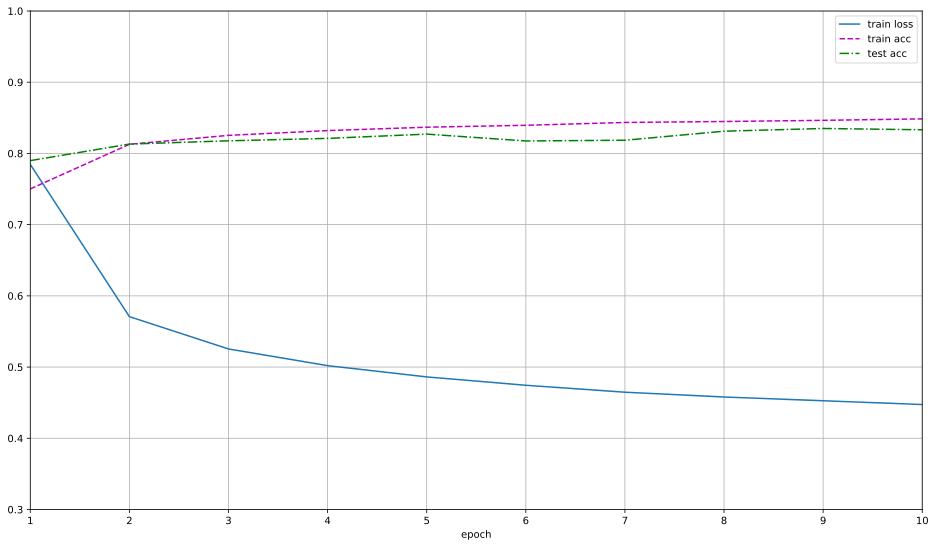

In [19]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

In [20]:
#num_epochs = 100
#train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

In [21]:
# 获取模型第一个参数的设备
device = W.device
print(device)  # 输出: cpu 或 cuda:0 等

cpu


Model device: cuda:0
train_loss=0.3799, train_acc=0.8684, test_acc=0.8418


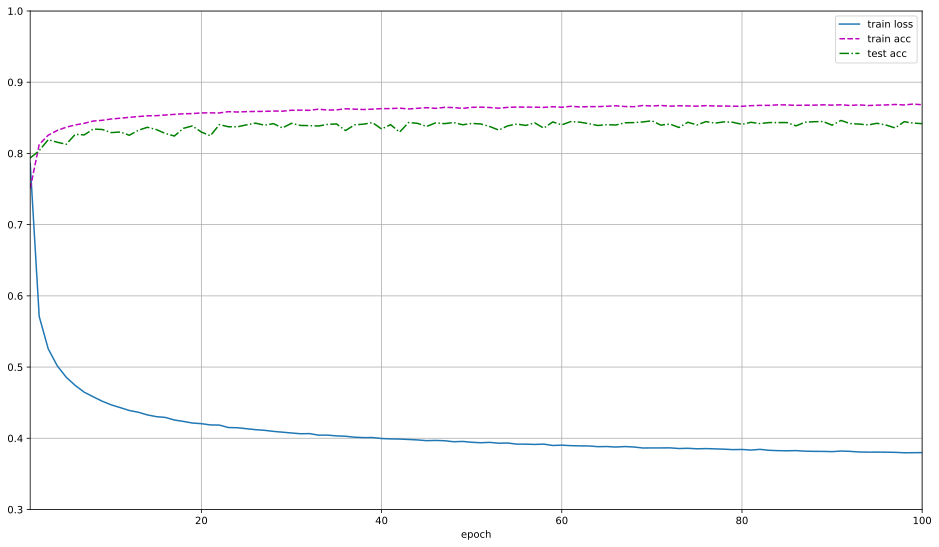

In [27]:
# ======================
# 启用 GPU 支持（不修改原有函数）
# ======================

# 1. 检查 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 2. 将模型参数移到 GPU（必须！）
W_GPU = torch.normal(
    0, 0.01,
    size=(num_inputs, num_outputs),
    requires_grad=True,
    device=device
)
b_GPU = torch.zeros(num_outputs, requires_grad=True, device=device)


# 3. ⭐️ 重新定义 net 函数！⭐️（解决闭包引用旧 CPU 张量的问题）
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W_GPU.shape[0])), W_GPU) + b_GPU)

def train_epoch_ch3_GPU(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

def evaluate_accuracy_GPU(net, data_iter):
    metric = Accumulator(2)  # 正确数，总数
    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train_ch3_GPU(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(
        xlabel='epoch',
        xlim=[1, num_epochs],
        ylim=[0.3, 1],
        legend=['train loss', 'train acc', 'test acc']
    )

    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3_GPU(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy_GPU(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))

    train_loss, train_acc = train_metrics
    print("Model device:", next(iter([W_GPU])).device)
    print(
        f"train_loss={train_loss:.4f}, "
        f"train_acc={train_acc:.4f}, "
        f"test_acc={test_acc:.4f}"
    )
# 6. 现在可以安全训练了！
lr = 0.1
num_epochs = 100
train_ch3_GPU(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

## 预测

现在训练已经完成，我们的模型已经准备好[**对图像进行分类预测**]。
给定一系列图像，我们将比较它们的实际标签（文本输出的第一行）和模型预测（文本输出的第二行）。


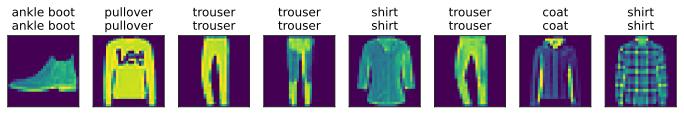

In [206]:
def predict_ch3(net, test_iter, n=8):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

## 小结

* 借助softmax回归，我们可以训练多分类的模型。
* 训练softmax回归循环模型与训练线性回归模型非常相似：先读取数据，再定义模型和损失函数，然后使用优化算法训练模型。大多数常见的深度学习模型都有类似的训练过程。

## 练习

1. 本节直接实现了基于数学定义softmax运算的`softmax`函数。这可能会导致什么问题？提示：尝试计算$\exp(50)$的大小。
1. 本节中的函数`cross_entropy`是根据交叉熵损失函数的定义实现的。它可能有什么问题？提示：考虑对数的定义域。
1. 请想一个解决方案来解决上述两个问题。
1. 返回概率最大的分类标签总是最优解吗？例如，医疗诊断场景下可以这样做吗？
1. 假设我们使用softmax回归来预测下一个单词，可选取的单词数目过多可能会带来哪些问题?


[Discussions](https://discuss.d2l.ai/t/1789)
